In [15]:
import scipy.io as sio
import numpy as np 
import sys 
from matplotlib import pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
import itertools

In [3]:
# #145 145 220
# def main():
#     # See https://rslab.ut.ac.ir/data for information about this dataset (Urban)
#     hs_image = sio.loadmat("data/Urban_R162.mat")
#     # print(type(hs_image))

#     # for key in hs_image:
#     #     print(key)

#     # Channels that are kept 
#     # print(hs_image["SlectBands"])

#     # Size of image 
#     # print(hs_image["nRow"])
#     # print(hs_image["nCol"])

#     # Number of wavelengths 
#     # print(hs_image["nBand"])

#     # Matrix itself 
#     # print(hs_image["Y"])

#     # Not sure what this mean 
#     # print(hs_image["maxValue"])

    
#     matrix = np.array(hs_image["Y"])

#     # Each row correspond to a channel/wavelength and the image is vectorized as a row vector (I am not sure how it is being flatten) 
#     # I am not sure what the value in the matrix mean. They range from 0 to 1000. I am guessing it is how much is captured by a particular channel after normalization  
#     print(matrix)

# main()

In [4]:
hs_image = sio.loadmat("data/Urban_R162.mat")
for key in hs_image:
    print(key)

print(hs_image["SlectBands"])

__header__
__version__
__globals__
SlectBands
nRow
nCol
nBand
Y
maxValue
[[  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [154]
 [155]
 [156]
 [157]
 [158]
 [159]
 [160]
 [161]
 [162]
 [163]
 [164]
 [165]
 [166]
 [167]
 [1

In [5]:
# for i in range(0,6):
#     fst_row = H[i]
#     fst_image = H[i].reshape((307, 307))

#     plt.imshow(fst_image, interpolation='nearest')
#     plt.show()

In [6]:
@jit(nopython=True, parallel=True)
def nmf_hs(X, delta, iters, components):
    (rows, cols) = X.shape
    A = np.random.rand(rows, components)
    S = np.random.rand(components, cols)
    all_delta_X = delta * np.ones((1, cols))
    all_delta_A = delta * np.ones((1, components))
    X_bar = np.vstack((X, all_delta_X))
    for _ in range(0, iters):
        A = A * (X @ np.transpose(S)) / (A @ S @ np.transpose(S))
        A_bar = np.vstack((A, all_delta_A))
        S = S * (np.transpose(A_bar) @ X_bar) / (np.transpose(A_bar) @ A_bar @ S)
        print(np.linalg.norm(X - A @ S))
    error = (np.linalg.norm(X - A @ S))
    return A, S, error 

In [7]:
hs_image = sio.loadmat("data/Urban_R162.mat")
X = np.array(hs_image["Y"]).astype(np.float64)

W, H, error = nmf_hs(X, 1000.0, 200, 6)
error 

442095.70236102224
281611.5956918265
259311.36403580115
250286.25625389552
245145.4410474492
241480.5083295221
238355.271614909
235250.79545305093
231764.65762086186
227503.57312284183
222053.5584021013
215012.11417375898
206092.2047401045
195288.7873739022
183034.13473656765
170204.68731129452
157889.62043117997
147018.56274379374
138086.17986523843
131122.68519573222
125852.77788188828
121890.25900750364
118868.88148922125
116496.30596097822
114559.45928697784
112910.11877333414
111447.12366602654
110101.52623697823
108825.87804984693
107587.00806948387
106361.30280261839
105131.65163748738
103885.46301772635
102613.36152635905
101308.3214060575
99965.08828967689
98579.80206898264
97149.77115860909
95673.36952088388
94150.03749639814
92580.36880326144
90966.26132923043
89311.10083786887
87619.93720446127
85899.60562040105
84158.74387385116
82407.66418049429
80658.05518675494
78922.51512273653
77213.94622960238
75544.86715264687
73926.7174621567
72369.2323368346
70879.95482168622
6946

32540.346536268775

In [8]:
np.ones((1, 6)) @ H

array([[0.9967914 , 0.99622706, 0.99579494, ..., 0.99623136, 0.99704462,
        0.99736255]])

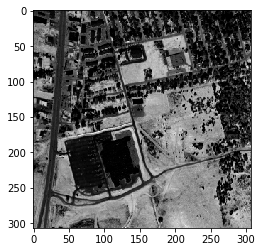

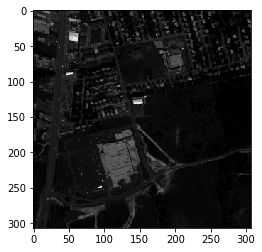

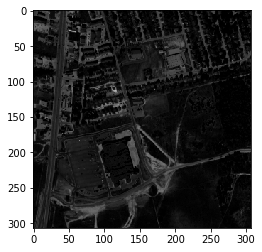

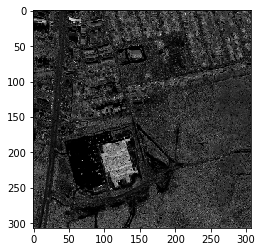

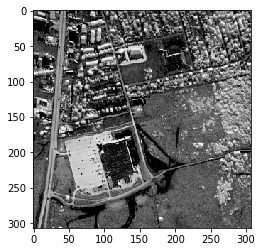

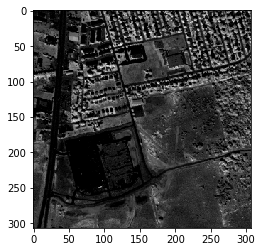

In [9]:
for i in range(0,6):
    fst_row = H[i]
    fst_image = H[i].reshape((307, 307))

    plt.imshow(fst_image, cmap='gray', interpolation='nearest')
    plt.show()

In [10]:
wavelength = hs_image["SlectBands"]

def radiation_expected(wavelength):
    return 3.8 * 10**8 / wavelength

def convertWToReflectivity(W):
    if(len(wavelength) != len(W)): return None
    newW = []

    for i in range(len(W)):
        newRow = []
        for j in range(len(W[i])):
            val =( W[i][j] / radiation_expected(wavelength[i])) * 100
            newRow += [val]
        newW += [newRow]

    newW = np.array(newW)[:,:,0]
    return newW

def plot_endmembers(W, n_comps, title="Endmembers"):
    W_t = W.transpose()
    bands = range(162)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.xlabel("Bands")
    plt.ylabel("Reflectance")
    plt.title(title)
    for i in range(n_comps):
        plt.plot(bands, W_t[i], color = colors[i])
    plt.show()

(162, 6)
(162, 6)


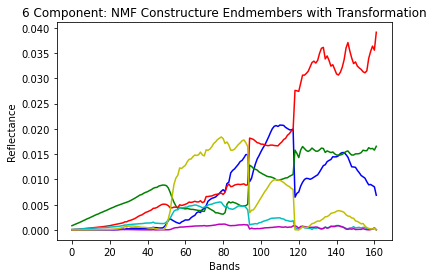

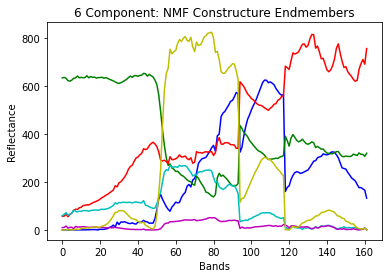

In [11]:
print(W.shape)

W_reflection = convertWToReflectivity(W)
# print(W_reflection)
print(W_reflection.shape)

plot_endmembers(W_reflection, 6, title="6 Component: NMF Constructure Endmembers with Transformation")
plot_endmembers(W, 6, title="6 Component: NMF Constructure Endmembers")



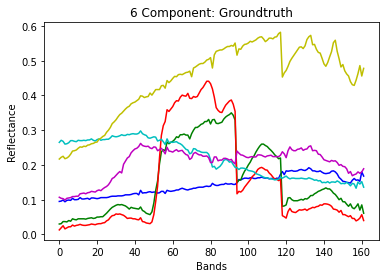

In [12]:
hs_image = sio.loadmat("data/groundTruth_Urban_end6/end6_groundTruth.mat")

W_gt6 = hs_image["M"]
plot_endmembers(W_gt6, 6, title="6 Component: Groundtruth")



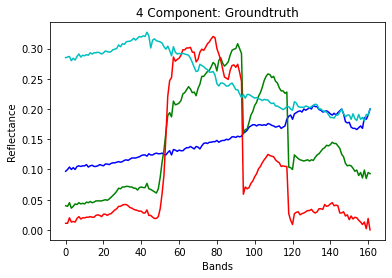

In [13]:
hs_image = sio.loadmat("data/groundTruth/end4_groundTruth.mat")

W_gt4 = hs_image["M"]
plot_endmembers(W_gt4, 4, title="4 Component: Groundtruth")


In [16]:

# Get all permutations of the rows of W_reflection
perms = list(itertools.permutations(W_reflection.transpose()))

# Calculate RMS for each permutation
rms_list = []
for perm in perms:
    rms = mean_squared_error(W_gt6.transpose(), perm, squared=False)
    rms_list.append(rms)

# Find the permutation with the lowest RMS
min_rms = min(rms_list)
min_perm = perms[rms_list.index(min_rms)]

print("Minimum RMS:", min_rms)

Minimum RMS: 0.24515165994406246
